Data Ducks

In [36]:
import os
 
print("username:" , os.getlogin())
import datetime

today = datetime.date.today()
print("Today's date:", today)

username: raunaksengupta
Today's date: 2022-11-16


In [37]:
import findspark
findspark.init()

In [38]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("mini_project")\
.getOrCreate()

In [39]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

/Users/raunaksengupta/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [40]:
from platform import python_version

print(python_version())
sc.version #spark version

3.8.8


'3.3.0'

In [41]:
#Read File
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [42]:
# replace "." in column names with "_"

# df=df.withColumn("empvarrate",df.'emp.var.rate')

new_cols=(column.replace('.', '_') for column in df.columns)
df = df.toDF(*new_cols)

In [43]:
# EDA - ID numeric and categorical variables

string_columnList = [item[0] for item in df.dtypes if item[1].startswith('string')]
int_columnList = [item[0] for item in df.dtypes if item[1].startswith('integer')]
double_columnList = [item[0] for item in df.dtypes if item[1].startswith('double')]

int_columnList,double_columnList,string_columnList

Numerical = int_columnList+double_columnList
Categorical = string_columnList



numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
num_features = numeric_features + double_columnList

In [44]:
# EDA - convert zeros to nulls values

from pyspark.sql.functions import when
df=df.withColumn("duration",when(df.duration==0,np.nan).otherwise(df.duration))
df=df.withColumn("pdays",when(df.pdays==0,np.nan).otherwise(df.pdays))
df=df.withColumn("previous",when(df.previous==0,np.nan).otherwise(df.previous))

In [45]:
df.select(num_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934043,17,98
duration,41188,NaN,NaN,1.0,NaN
campaign,41188,2.567592502670681,2.770013542902331,1,56
pdays,41188,NaN,NaN,1.0,NaN
previous,41188,NaN,NaN,1.0,NaN
emp_var_rate,41188,0.08188550063178966,1.57095974051703,-3.4,1.4
cons_price_idx,41188,93.5756643682899,0.5788400489540823,92.201,94.767
cons_conf_idx,41188,-40.502600271918276,4.628197856174573,-50.8,-26.9
euribor3m,41188,3.621290812858533,1.7344474048512595,0.634,5.045


In [46]:
# EDA - impute missing variables

from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["age","duration","campaign","pdays","previous"],
                outputCols=["age","duration","campaign","pdays","previous"],
               strategy = 'mean')
model=imputer.fit(df)
df=model.transform(df)


In [47]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head(21).T

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [48]:
#half = int(len(imputed_data.columns)/2)
#imputed_data.select(imputed_data.columns[:half]).show(5)

In [49]:
#imputed_data.select(imputed_data.columns[half:]).show(5)

In [50]:
# Previous Outcome Variable Distribution 

df.groupby("poutcome").count().show()

+-----------+-----+
|   poutcome|count|
+-----------+-----+
|    success| 1373|
|    failure| 4252|
|nonexistent|35563|
+-----------+-----+



In [51]:
# Target Variable Distribution 

df.groupby("y").count().show()

+---+-----+
|  y|count|
+---+-----+
| no|36548|
|yes| 4640|
+---+-----+



In [52]:
36548 / 4640

7.876724137931035

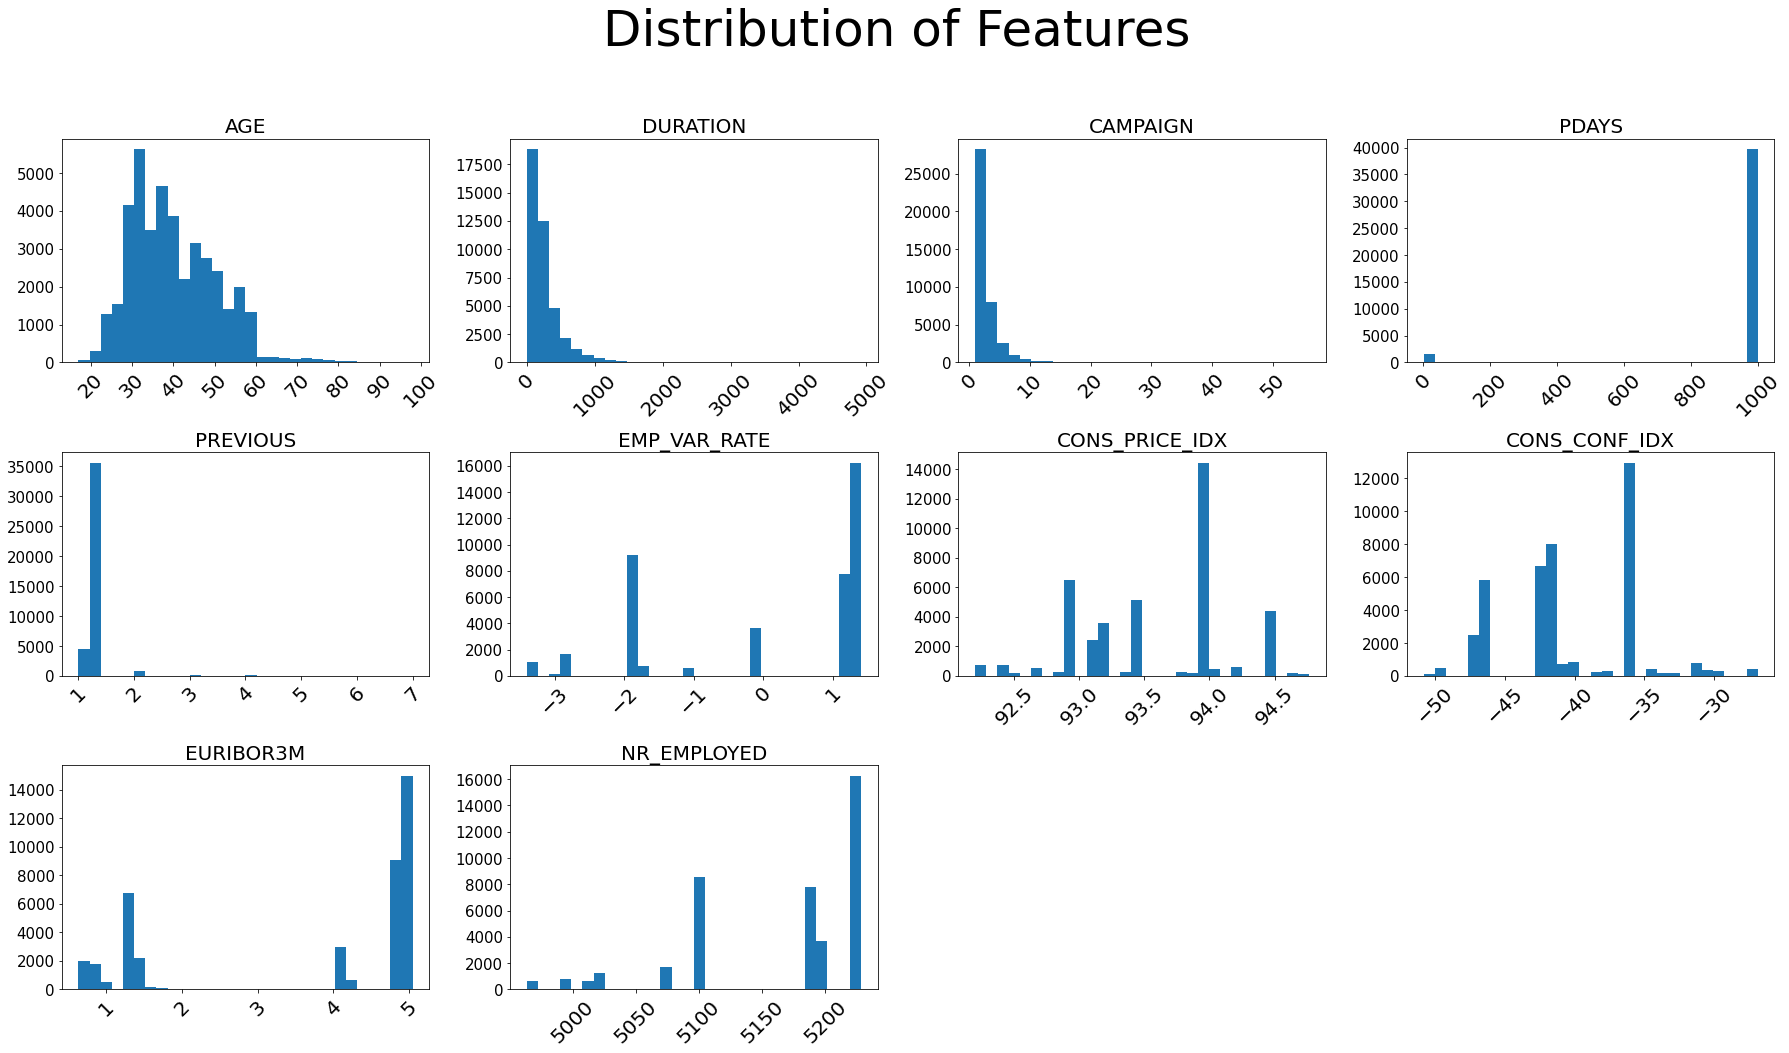

In [53]:
# Distribution of Features

from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(num_features, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col], bins = 30)
    
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [54]:
#Drop PDAYS, it could be converted to binary, but the information it would convey would be covered by Previous = 0
df = df.drop('pdays')

In [55]:
#Apply Log Transformations
from pyspark.sql.functions import log10
from pyspark.sql.functions import col

df = df.withColumn("log_duration", log10(col("duration")+ 0.001)).drop('duration')
df = df.withColumn("log_age", log10(col("age")+ 0.001)).drop('age')
df = df.withColumn("log_campaign", log10(col("campaign") + 0.001)).drop('campaign')
#df = df.withColumn("log_previous", log10(col("previous")+ 0.001)).drop('previous')

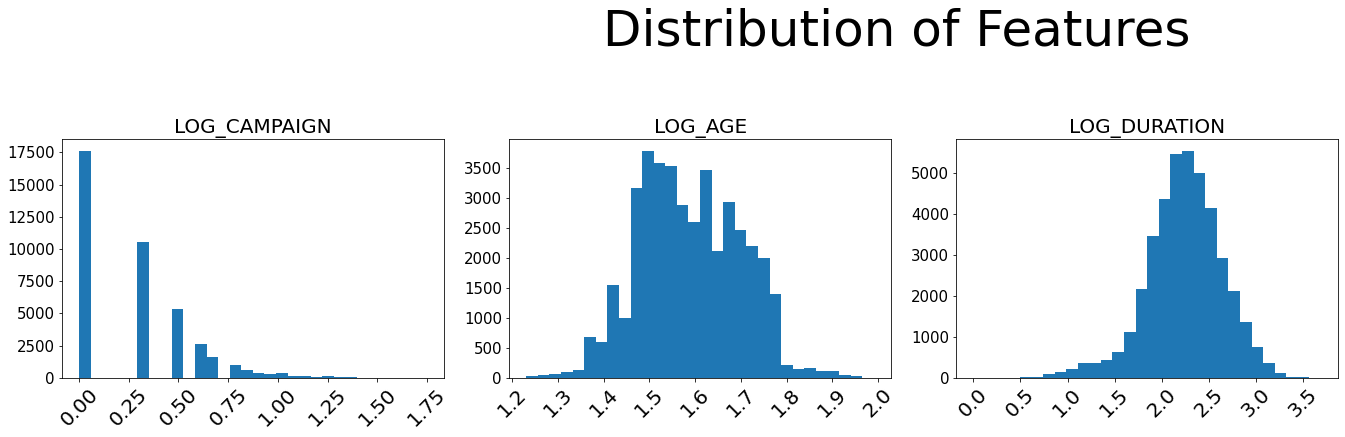

In [56]:
log_cols = ["log_campaign", "log_age", "log_duration"]

fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(log_cols, range(1,11)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col], bins = 30)
    
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [57]:
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

In [58]:
# Pearson Correlation

numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
numeric_features_df.toPandas().head()

,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,log_duration,log_age,log_campaign
0,1.266489,1.1,93.994,-36.4,4.857,5191.0,2.416642,1.748196,0.000434
1,1.266489,1.1,93.994,-36.4,4.857,5191.0,2.173189,1.755882,0.000434
2,1.266489,1.1,93.994,-36.4,4.857,5191.0,2.354110,1.568213,0.000434
3,1.266489,1.1,93.994,-36.4,4.857,5191.0,2.178980,1.602071,0.000434
4,1.266489,1.1,93.994,-36.4,4.857,5191.0,2.487140,1.748196,0.000434


In [59]:
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,log_duration,log_age,log_campaign
previous,1.000000,-0.011035,0.134630,0.076898,-0.053001,-0.142596,0.035285,0.007328,-0.005292
emp_var_rate,-0.011035,1.000000,0.775334,0.196041,0.972245,0.906970,-0.043713,0.035216,0.156358
cons_price_idx,0.134630,0.775334,1.000000,0.058986,0.688230,0.522034,-0.009908,0.017461,0.125587
cons_conf_idx,0.076898,0.196041,0.058986,1.000000,0.277686,0.100513,0.027625,0.120906,-0.016240
euribor3m,-0.053001,0.972245,0.688230,0.277686,1.000000,0.945154,-0.044835,0.047984,0.137441
nr_employed,-0.142596,0.906970,0.522034,0.100513,0.945154,1.000000,-0.065716,0.024732,0.148539
log_duration,0.035285,-0.043713,-0.009908,0.027625,-0.044835,-0.065716,1.000000,0.003795,-0.147600
log_age,0.007328,0.035216,0.017461,0.120906,0.047984,0.024732,0.003795,1.000000,0.004871
log_campaign,-0.005292,0.156358,0.125587,-0.016240,0.137441,0.148539,-0.147600,0.004871,1.000000


[Text(0.5, 0, 'previous'),
 Text(1.5, 0, 'emp_var_rate'),
 Text(2.5, 0, 'cons_price_idx'),
 Text(3.5, 0, 'cons_conf_idx'),
 Text(4.5, 0, 'euribor3m'),
 Text(5.5, 0, 'nr_employed'),
 Text(6.5, 0, 'log_duration'),
 Text(7.5, 0, 'log_age'),
 Text(8.5, 0, 'log_campaign')]

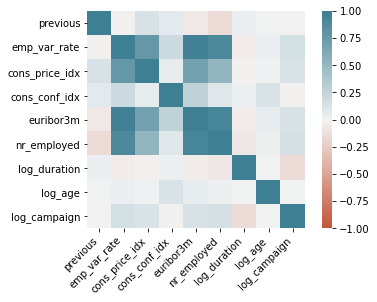

In [60]:
#Correlation Matrix Plot 

ax = sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [61]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head(21).T

,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0
previous,0


In [62]:
pd.set_option('display.max_colwidth', 80)
pd.set_option("display.max_columns", 12)

In [63]:
#dummy code categorical variables

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = f'{categoricalCol}Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[f"{categoricalCol}classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['log_age', 'log_duration', 'log_campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid="skip") # use setHandleInvalid("skip")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

cols = df.columns
print(cols)
print(stages)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y', 'log_duration', 'log_age', 'log_campaign']
[StringIndexer_920d6df1af65, OneHotEncoder_1f2a6b97c124, StringIndexer_cb908e41dc07, OneHotEncoder_c36e5b0a4852, StringIndexer_dbced0b704a0, OneHotEncoder_ce6211aea1b6, StringIndexer_8c7dbdedb24c, OneHotEncoder_7d3edfe25f10, StringIndexer_11f5a0cd1bc1, OneHotEncoder_7574ba3d62a6, StringIndexer_9a4b26488af7, OneHotEncoder_fe5f3ae1a03b, StringIndexer_aeb741c5281c, OneHotEncoder_c67fa30e9279, StringIndexer_cd70ea72db95, OneHotEncoder_97b27f33797d, StringIndexer_ca4eb753a960, OneHotEncoder_912de4241ac6, StringIndexer_0cc21bdc0e18, OneHotEncoder_a29dda3c29ec, StringIndexer_8dd6f3c904e8, VectorAssembler_955920c07b6d, StandardScaler_6039ea437fe1]


In [64]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_test = pipelineModel.transform(df)
#selectedCols = ['labels', 'features_new'] + cols
#df_test = df_test.select(selectedCols)

pd.set_option('display.max_columns', None)
df_test.toPandas().head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y,log_duration,log_age,log_campaign,jobIndex,jobclassVec,maritalIndex,maritalclassVec,educationIndex,educationclassVec,defaultIndex,defaultclassVec,housingIndex,housingclassVec,loanIndex,loanclassVec,contactIndex,contactclassVec,monthIndex,monthclassVec,day_of_weekIndex,day_of_weekclassVec,poutcomeIndex,poutcomeclassVec,label,vectorized_features,features
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1.266489,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2.416642,1.748196,0.000434,8.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.315223743272895, 0.0, 0.0, 2.0457..."
1,services,married,high.school,unknown,no,no,telephone,may,mon,1.266489,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2.173189,1.755882,0.000434,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045..."
2,services,married,high.school,no,yes,no,telephone,may,mon,1.266489,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2.354110,1.568213,0.000434,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045..."
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,1.266489,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2.178980,1.602071,0.000434,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(2.300140577866327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0457..."
4,services,married,high.school,no,no,yes,telephone,may,mon,1.266489,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,2.487140,1.748196,0.000434,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,(0.0),0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.045..."



### TODO
-  Assemble single Vector
- split data? or is this handled by the cv? I'm not sure
- Create models
    - Decision Tree
    - Logistic Regression
    - RandomForest
    - GBT
- Create grid search per model
- create cv
- add everything to pipeline
- compare results, likely via AUC since this is a binary target with some imbalance

In [32]:
#Split data
train, test = df_test.select(['label','features']).randomSplit([0.75, 0.25], seed = 29)

In [33]:
#Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

tree = DecisionTreeClassifier(labelCol = 'label')

tree_params = ParamGridBuilder()
tree_params.addGrid(tree.maxDepth, [5,10,15]) \
.addGrid(tree.impurity, ['gini','entropy']) \
.build()

tree_pipeline = Pipeline(stages = [tree])

In [40]:
#Forest
from pyspark.ml.classification import RandomForestClassifier

forest = RandomForestClassifier(labelCol = 'label')

forest_params = ParamGridBuilder()
forest_params.addGrid(forest.featureSubsetStrategy, ['auto','sqrt','0.8']).build() \
#.addGrid(forest.impurity, ['gini', 'entropy']) \
#.addGrid(forest.maxDepth, [6,10,12]) \
#.addGrid(forest.numTrees, [25,50,100,150]) \
#.build()

forest_pipeline = Pipeline(stages = [forest])

In [35]:
#Logistic
from pyspark.ml.classification import LogisticRegression

logistic = LogisticRegression(labelCol = 'label', standardization = True)

logistic_params = ParamGridBuilder()
logistic_params.addGrid(logistic.elasticNetParam, [0,0.25,0.5,0.75,1]) \
.build()

logistic_pipeline = Pipeline(stages = [logistic])

In [36]:
#GBT
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol = 'label')
gbt_params = ParamGridBuilder()
gbt_params.addGrid(gbt.maxIter, [15,25,50]) \
.build()

[{Param(parent='GBTClassifier_daaf135a88cc', name='maxIter', doc='max number of iterations (>= 0).'): 15},
 {Param(parent='GBTClassifier_daaf135a88cc', name='maxIter', doc='max number of iterations (>= 0).'): 25},
 {Param(parent='GBTClassifier_daaf135a88cc', name='maxIter', doc='max number of iterations (>= 0).'): 50}]

In [37]:
#Make Evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binary_evaluator = BinaryClassificationEvaluator()

In [41]:
#Cross Validate
#from statistics import mean
models = [logistic, gbt, forest, tree]
params = [logistic_params, gbt_params, forest_params, tree_params]

results = {}

for i in range(len(models)):
    cv = CrossValidator(
        estimator = models[i],
        estimatorParamMaps = params[i].build(),
        evaluator = binary_evaluator,
        numFolds = 4,
        seed = 29)
    cvModel = cv.fit(train)
    prediction = cvModel.transform(test)
    auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName:"areaUnderROC"})
    results[models[i]] = auc
    
print(results)

#should take about an hour to run

{LogisticRegression_937d9d22ea5b: 0.935640347007794, GBTClassifier_daaf135a88cc: 0.9462496324069989, RandomForestClassifier_7f9d8a09ba26: 0.9354590777091603, DecisionTreeClassifier_a6119853ddbc: 0.8508428907513601}


In [45]:
#Look at feature importance
cv = CrossValidator(
        estimator = models[1],
        estimatorParamMaps = params[1].build(),
        evaluator = binary_evaluator,
        numFolds = 4,
        seed = 29)
cvModel = cv.fit(train)
prediction = cvModel.transform(test)
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName:"areaUnderROC"})
cvModel.bestModel

GBTClassificationModel: uid = GBTClassifier_daaf135a88cc, numTrees=50, numClasses=2, numFeatures=52

In [50]:
cvModel.bestModel.save('GBT_champ')

SparseVector(52, {0: 0.0018, 1: 0.0044, 2: 0.0042, 3: 0.001, 4: 0.0026, 5: 0.0029, 6: 0.0038, 7: 0.0036, 8: 0.0049, 9: 0.0036, 10: 0.0018, 11: 0.0024, 12: 0.0024, 13: 0.001, 14: 0.007, 15: 0.0014, 16: 0.0052, 17: 0.0011, 18: 0.0053, 19: 0.005, 20: 0.0015, 21: 0.0066, 22: 0.0065, 23: 0.0016, 24: 0.002, 25: 0.003, 26: 0.0016, 27: 0.019, 28: 0.0019, 29: 0.0037, 30: 0.0007, 31: 0.0018, 32: 0.0053, 33: 0.0074, 34: 0.0094, 35: 0.0006, 36: 0.01, 37: 0.0059, 38: 0.0052, 39: 0.0067, 40: 0.0139, 41: 0.015, 42: 0.0222, 43: 0.0564, 44: 0.346, 45: 0.0331, 46: 0.0119, 47: 0.0178, 48: 0.0314, 49: 0.0406, 50: 0.0956, 51: 0.1503})

In [65]:
#K-Means Clustering 
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(df_test)
data_scale_output=data_scale.transform(df_test)
data_scale_output.show(2)

+---------+-------+-----------+-------+-------+----+---------+-----+-----------+-----------------+-----------+------------+--------------+-------------+---------+-----------+---+------------------+------------------+--------------------+--------+--------------+------------+---------------+--------------+-----------------+------------+---------------+------------+---------------+---------+-------------+------------+---------------+----------+-------------+----------------+-------------------+-------------+----------------+-----+--------------------+--------------------+--------------------+
|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|         previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|      log_duration|           log_age|        log_campaign|jobIndex|   jobclassVec|maritalIndex|maritalclassVec|educationIndex|educationclassVec|defaultIndex|defaultclassVec|housingIndex|housingclassVec|loanIndex| loanclassVe

In [66]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.17994674100585545
Silhouette Score: 0.18485257210789308
Silhouette Score: 0.09126632791496504
Silhouette Score: 0.0648147868456419
Silhouette Score: 0.07509213068095252
Silhouette Score: 0.09290373487088417
Silhouette Score: 0.08914887071101023
Silhouette Score: 0.11457219031373082


Text(0, 0.5, 'Silhouette_Score')

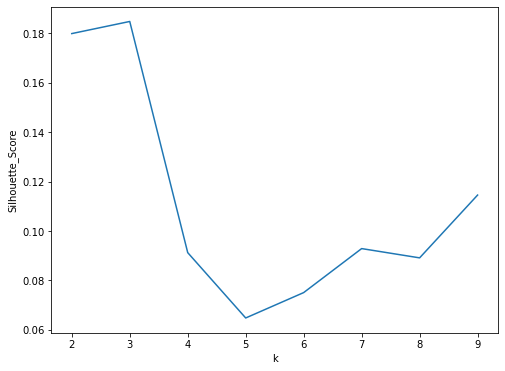

In [67]:
#Visualizing the silhouette scores in a plot
# A cluster of 6 is optimal; K=6 is where a local maxima of Silhouette Score is observed.


import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette_Score')